In [19]:
import multiprocessing
import tqdm

import numpy as np
import scipy.stats as st
import numba

#import biocircuits

# Plotting modules
import bokeh.io
import bokeh.plotting

import scipy
bokeh.io.output_notebook()

# Line profiler (can install with conda install line_profiler)
#%load_ext line_profiler

Loading BokehJS ...

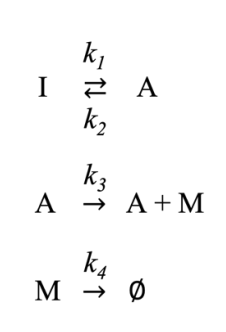

In [2]:
# Column 0 is change in m, column 1 is change in p

#[I, A, M]

simple_update = np.array([[-1, +1, 0],   # Change of I to A
                          [+1, -1, 0],   # Change of A back to I
                          [ 0,  0, 1],   # A produces M
                          [ 0,  0,-1]],  # Degradation of M
                          dtype=int)

In [9]:
def expected_value(values, weights):
    values = np.asarray(values)
    weights = np.asarray(weights)
    return (values * weights).sum() / weights.sum()

In [3]:
def simple_propensity(propensities, population, t, k1, k2, k3, k4):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    I, A, M = population
    
    # Update propensitiesa
    
    propensities[0] = k1*I          # Change of I to A 
    propensities[1] = k2*A          # Change of A back to I
    propensities[2] = k3*A          # A produces M
    propensities[3] = k4*M          # Degradation of M

In [4]:
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [5]:
def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

In [6]:
def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

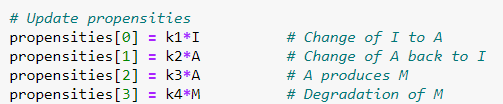

In [7]:
# Specify parameters for calculation
args = (18.0, 30.0, 10.0, 1)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([100, 0, 0], dtype=int)
size = 400

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 3), dtype=int)

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)

C:\Users\denni\AppData\Local\Temp\ipykernel_4448\2846320704.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/400 [00:00<?, ?it/s]

In [13]:
# Set up plots
plots = [bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='I'),
         bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='A'),
         bokeh.plotting.figure(plot_width=300,
                               plot_height=200,
                               x_axis_label='dimensionless time',
                               y_axis_label='M')]

# Plot trajectories and mean
for i in [0, 1, 2]:
    for x in samples[:,:,i]:
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=6, color='orange', line_join='bevel')

# Link axes
plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

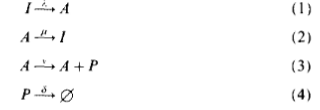

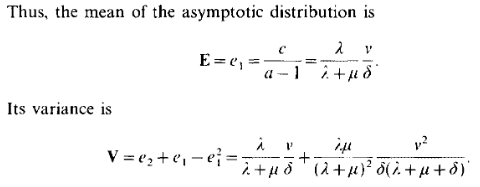

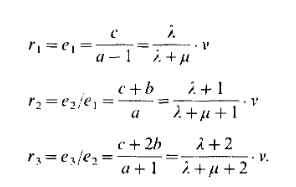

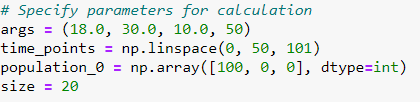

First moment

Using the mRNA concentration and calculating the mean of the final snapshot

In [14]:
e1 = samples[:, -1, 2].mean()

Second moment

Using the mRNA concentration and calculating the variance of the last 10 snapshots

In [17]:
e2 = np.array([np.var(np.array(samples[:, i, 2])) for i in range(-10, 0)]).mean()

Third moment 

Using the mRNA concentration and calculating the skew of the last 10 snapshots

In [20]:
e3 = np.array([scipy.stats.skew(np.array(samples[:, i, 2])) for i in range(-10, 0)]).mean()

Calculating the Rs from the paper

In [21]:
r1 = e1
r2 = e2/e1
r3 = e3/e2

Recalculating the rates;

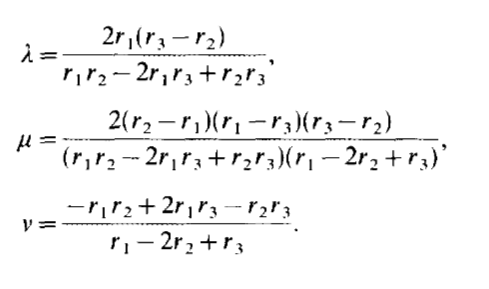

In [24]:
lambda_calc = 2*r1*(r3-r2)/(r1*r2 - 2*r1*r3 + r2*r3)
mu_calc = 2*(r2-r1)*(r1-r3)*(r3-r2)/((r1*r2 - 2*r1*r3 + r2*r3)*(r1 - 2*r2 + r3))
nu_calc = (-r1*r2 + 2*r1*r3 - r2*r3)/(r1 - 2*r2 + r3)

Calculated parameters

In [26]:
(lambda_calc, mu_calc, nu_calc, 1)

(-1.9999300429458267, 2.006008894657268, -1.1409263956926867, 1)

Simulation parameters

In [27]:
(args[0], args[1], args[2], args[3])

(18.0, 30.0, 10.0, 1)

The parameters do not match because the approximations in the paper is effective for a very narrow interval of parameters.